In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
print(customers.info())
print(products.info())
print(transactions.info())

print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

In [4]:
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

In [6]:
data['MonthYear'] = data['TransactionDate'].dt.to_period('M')
monthly_sales = data.groupby('MonthYear')['TotalValue'].sum()

top_products = data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)

region_revenue = data.groupby('Region')['TotalValue'].sum()

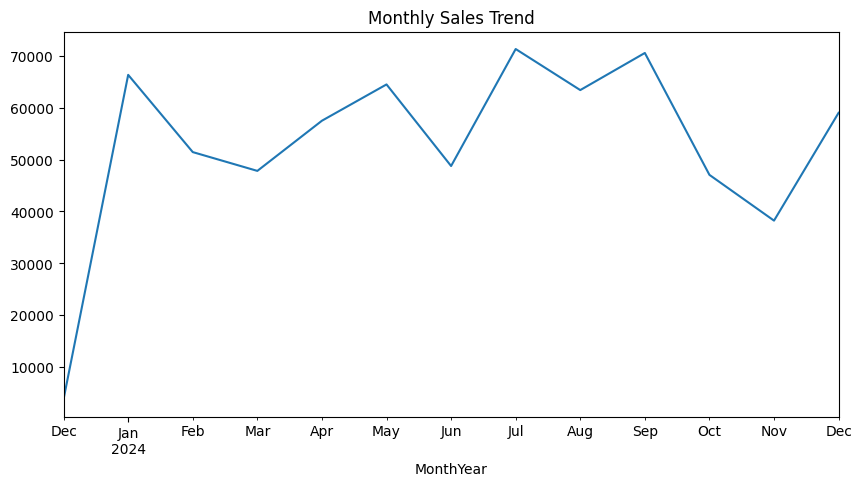

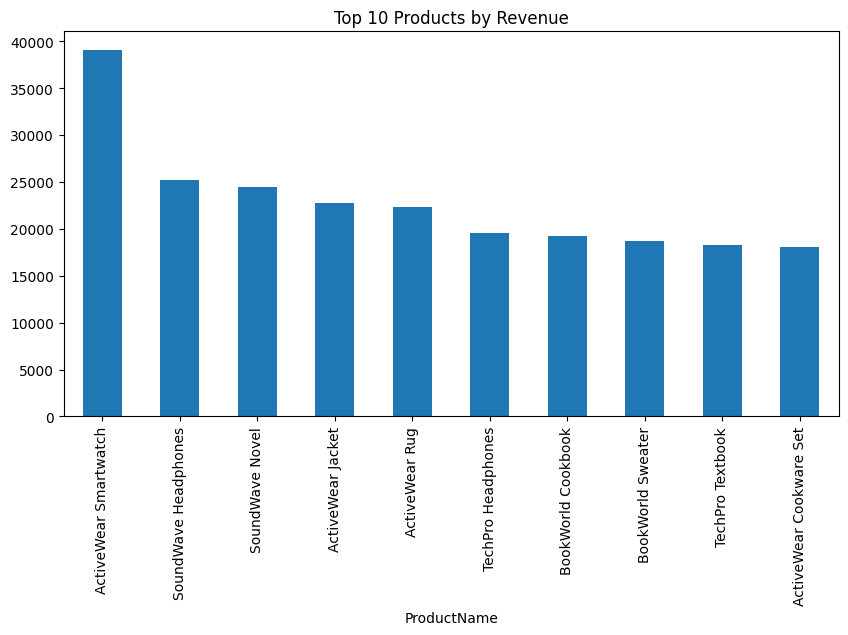

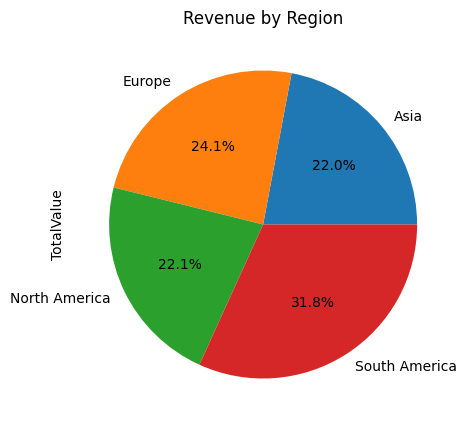

In [7]:
plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='line', title='Monthly Sales Trend')
plt.show()

plt.figure(figsize=(10, 5))
top_products.plot(kind='bar', title='Top 10 Products by Revenue')
plt.show()

plt.figure(figsize=(10, 5))
region_revenue.plot(kind='pie', autopct='%1.1f%%', title='Revenue by Region')
plt.show()

In [10]:
# Feature engineering
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
}).reset_index()

# Normalize features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalValue', 'Quantity']])

In [11]:
similarity_matrix = cosine_similarity(customer_features_scaled)

lookalikes = {}
for i, customer_id in enumerate(customer_features['CustomerID']):
    similar_customers = list(enumerate(similarity_matrix[i]))
    similar_customers = sorted(similar_customers, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_features.iloc[idx]['CustomerID'], round(score, 2)) for idx, score in similar_customers]

lookalikes_df = pd.DataFrame({
    'CustomerID': lookalikes.keys(),
    'Lookalikes': [str(v) for v in lookalikes.values()]
})
lookalikes_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)

In [12]:
customer_data = customers.merge(customer_features, on='CustomerID')

encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_data[['Region']]).toarray()

final_features = np.hstack((region_encoded, customer_features_scaled))

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(final_features)

customer_data['Cluster'] = clusters

Davies-Bouldin Index: 1.4451410863711214


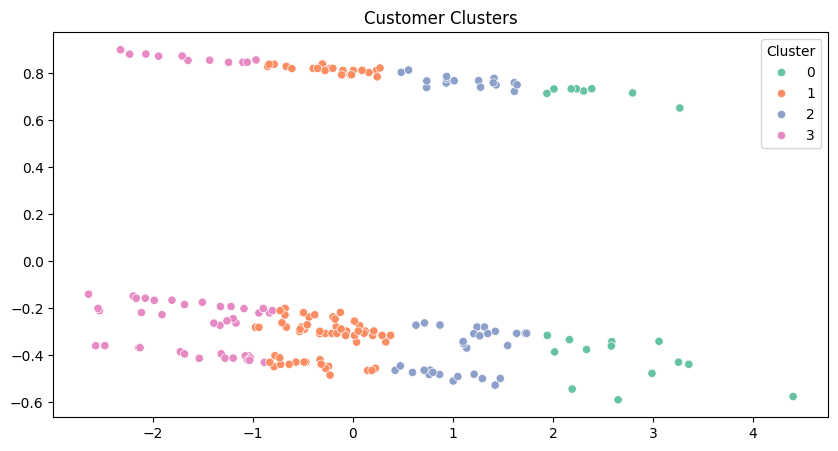

In [14]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(final_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

pca = PCA(n_components=2)
pca_features = pca.fit_transform(final_features)

plt.figure(figsize=(10, 5))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_data['Cluster'], palette='Set2')
plt.title('Customer Clusters')
plt.show()